In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [87]:

import polars as pl
import torch
from transformers.models.deberta_v2 import DebertaV2ForTokenClassification, DebertaV2TokenizerFast
import joblib, pdb, itertools
from functools import partial
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch, os, random
import torch.nn as nn
from transformers import AutoModel
from torch.optim import AdamW
from sklearn.metrics import fbeta_score, precision_score, recall_score
from multiprocessing import cpu_count
from sklearn.model_selection import train_test_split
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# args
model_directory = "/content/drive/MyDrive/kaggle_lstm/notebook/deberta_v3_small/"
stride = 100
# //60-> 71za
max_length  = 512
test_path = '/content/drive/MyDrive/kaggle_lstm/data/train.json'
agu_path = '/content/drive/MyDrive/kaggle_lstm/data/aug_train_v2.json'
aug_path_v3 = '/content/drive/MyDrive/kaggle_lstm/data/aug_train_v3.json'
model_ouput = '/content/drive/MyDrive/kaggle_lstm/notebook/demo.pt'

fetch_size =6807

seed = 0
pytorch_seed = 250
batch_size = 3

max_epochs = 3

tokenizer = DebertaV2TokenizerFast.from_pretrained(model_directory, device="cuda")


pii_tags = {
             0: 'O',
             1: 'I-URL_PERSONAL',
             2: 'B-USERNAME',
             3: 'B-NAME_STUDENT',
             4: 'B-STREET_ADDRESS',
             5: 'B-ID_NUM',
             6: 'B-EMAIL',
             7: 'B-URL_PERSONAL',
             8: 'I-PHONE_NUM',
             9: 'B-PHONE_NUM',
             10: 'I-NAME_STUDENT',
             11: 'I-STREET_ADDRESS',
             12: 'I-ID_NUM'
          }

reverser_pii = {j: i for i, j in pii_tags.items()}


num_labels = len(reverser_pii)



/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [5]:
def load_data(file_path, train=True):
    df = pl.read_json(file_path).lazy()
    reshaped_df = (
        df
        .with_columns(
            token_keys=pl.col('tokens')
            .map_elements(lambda f: [i for i in range(len(f))]),
        )
        .explode(['tokens', 'trailing_whitespace', 'token_keys'])
        .with_columns(
            token_len=pl.col('tokens').str.len_chars(),
        )
        .with_columns(
            token_len=pl.struct(['token_keys', 'token_len'])
            .map_elements(lambda f: [f['token_keys']] * f['token_len'])
        )
        .with_columns(
            token_len=pl.when(pl.col('trailing_whitespace') == True)
            .then(pl.col('token_len').list.concat(-1))
            .otherwise(pl.col('token_len')),
            tokens_rec=pl.when(pl.col('trailing_whitespace') == True)
            .then(pl.col('tokens').add(' '))
            .otherwise(pl.col('tokens'))
        )
        .group_by('document', maintain_order=True)
        .agg(
            tokens=pl.col('tokens'),
            token_key=pl.col('token_len').flatten(),
            tokens_rec=pl.col('tokens_rec')
        )
        .with_columns(
            token_rec=pl.col('tokens_rec')
            .list.join(separator='')
        )
        .drop('tokens_rec')
    )
    if train:
        temp = ((reshaped_df
                 .join(df.select(['document', 'labels'])
                       , on='document')
                 )
        )
    else:
        temp = reshaped_df
    return temp

In [6]:
def tokenize( a, b, tokenizer=tokenizer,stride = stride, max_length = max_length):
    txt = a.to_list()
    doc = b.to_list()

    inputs = tokenizer(txt ,
                       padding=True,
                       truncation=True,
                       return_offsets_mapping=True,
                       return_overflowing_tokens = True,
                       stride = stride,
                       add_special_tokens=True,
                       max_length= max_length,

                      )

    overflow_to_sample_mapping = inputs["overflow_to_sample_mapping"]

    doc_key = []
    for i, mapping in enumerate(overflow_to_sample_mapping):
        doc_key.append(doc[mapping])

    offset = inputs['offset_mapping']
    print(len(offset))
    attention_mask = inputs['attention_mask']
    input_ids = inputs['input_ids']
    txt_lst = []

    for token_ids in input_ids:
        tokens = tokenizer.convert_ids_to_tokens(token_ids)
        txt_lst.append(tokens)

    return {'txt':txt_lst,
            'attention_mask': attention_mask,
            'input_ids':input_ids,
            'offset': offset ,
            'doc': doc_key
           }

In [7]:
def align_lables(row):
    lbl = row['labels']
    offset = row['offset']
    tok_key = row['token_key']
    token_rec = row['token_rec']

    temp_list = []
    for start, end in offset:

        if (start== 0 and end ==0):
            temp_list.append('<PAD>')
            continue
        if tok_key[start] == -1:
            start += 1
        if token_rec[start].isspace():
             start += 1
        temp = tok_key[start]
        temp_list.append(lbl[temp])
    return temp_list

In [8]:
org_df = load_data(test_path, train = True).with_columns(db_source= pl.lit('orginal'))
agu_df = load_data(agu_path, train = True).with_columns(db_source= pl.lit('moth'))
agu_df_3 = load_data(aug_path_v3, train = True).with_columns(db_source= pl.lit('nicholas'))



In [9]:
org_df.fetch(1)

document,tokens,token_key,token_rec,labels,db_source
i64,list[str],list[i64],str,list[str],str
7,"[""Design"", ""Thinking"", … "" ""]","[0, 0, … 752]","""Design Thinkin…","[""O"", ""O"", … ""O""]","""orginal"""


In [10]:
agu_df.fetch(1)


document,tokens,token_key,token_rec,labels,db_source
i64,list[str],list[i64],str,list[str],str
57344,"[""My"", ""name"", … ""Street.""]","[0, 0, … 362]","""My name is Aal…","[""O"", ""O"", … ""I-STREET_ADDRESS""]","""moth"""


In [11]:
agu_df_3.fetch(1)



document,tokens,token_key,token_rec,labels,db_source
i64,list[str],list[i64],str,list[str],str
65541,"[""Tiburce"", ""Evans"", … ""Evans""]","[0, 0, … 1096]","""Tiburce Evans,…","[""B-NAME_STUDENT"", ""I-NAME_STUDENT"", … ""I-NAME_STUDENT""]","""nicholas"""


In [12]:

temp = pl.concat([org_df,  agu_df, agu_df_3, ], how="vertical_relaxed").lazy()
split_set = temp.select('document').collect().to_pandas()
X_temp, X_test= train_test_split(split_set, test_size=0.2, random_state=seed, shuffle=True)
X_train, X_val= train_test_split(X_temp, test_size=0.2, random_state=seed, shuffle=True)
X_train, X_val= train_test_split(X_temp, test_size=0.25, random_state=42, shuffle=True)

train_filter = X_train.loc[:, 'document'].to_list()
vali_filter = X_val.loc[:, 'document'].to_list()
test_filter = X_test.loc[:, 'document'].to_list()

In [13]:

%%time
test = temp.filter(pl.col('document').is_in(test_filter)).collect()


CPU times: user 1min 27s, sys: 7.53 s, total: 1min 35s
Wall time: 1min 33s


In [14]:

%%time
vali_ = temp.filter(pl.col('document').is_in(vali_filter)).collect()


CPU times: user 1min 27s, sys: 7.67 s, total: 1min 35s
Wall time: 1min 33s


In [15]:

%%time
train_ = temp.filter(pl.col('document').is_in(train_filter)).collect()

CPU times: user 1min 29s, sys: 8.62 s, total: 1min 37s
Wall time: 1min 35s


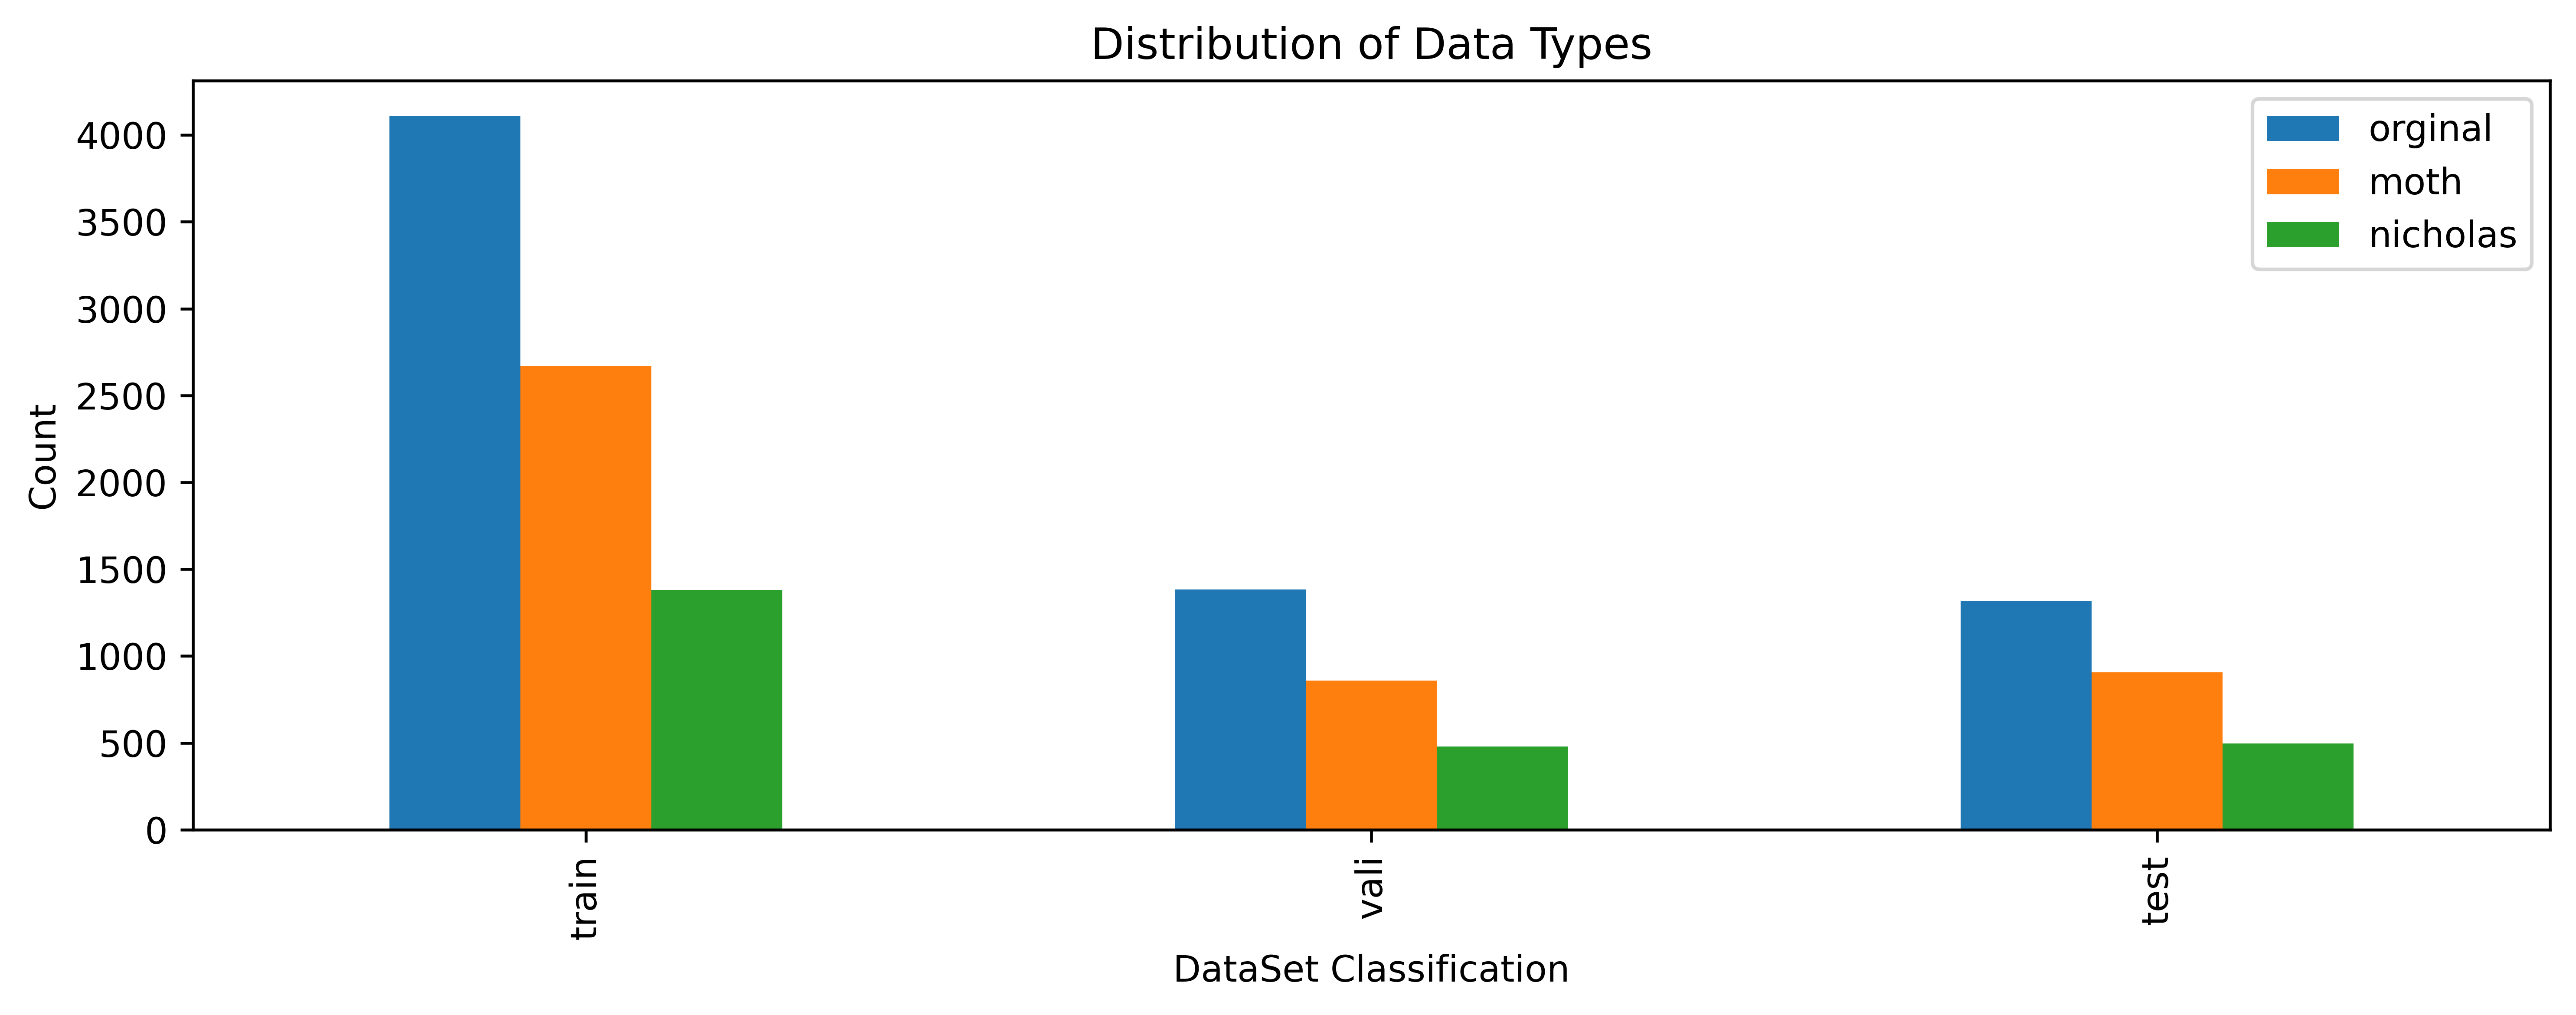

In [16]:

fig, ax = plt.subplots(dpi = 600, figsize =(10,4) )

(
  (
  pl.concat([

      train_.with_columns(type_ = pl.lit('train')),
      vali_.with_columns(type_ = pl.lit('vali')),
      test.with_columns(type_ = pl.lit('test'))

  ], how = 'vertical_relaxed'
  )
  .select(pl.col('type_'), pl.col('db_source'))
  .with_columns(
      count = pl.lit(1)
  )
  )
  .pivot(values ='count', columns = 'db_source', index = 'type_', aggregate_function = "count")
  .to_pandas()
  .set_index('type_')
  .plot
  .bar(ax = ax)

)

ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_title('Distribution of Data Types')

plt.tight_layout()
plt.show()




In [51]:
def create_summary(df):
  return (df
 .lazy()
 .explode(pl.col('labels'))
 .filter(pl.col('labels') !="O")
 .select(['db_source', 'labels'])

 .group_by(['labels', 'db_source'])
 .agg(
     count = pl.col('db_source').count()

 )
 .with_columns(
      total=pl.sum('count').over('labels')

 )
.with_columns(
    percentage=pl.col('count') / pl.col('total')
)

 .collect()
 .pivot(values = ['count'],
        columns = 'db_source',
        index = 'labels',
        aggregate_function = "sum"
        )
 .fill_null(0)
 .sort('labels')
)


In [52]:
#train
create_summary(train_)


labels,orginal,nicholas,moth
str,u32,u32,u32
"""B-EMAIL""",17,1447,2295
"""B-ID_NUM""",48,1396,0
"""B-NAME_STUDENT…",817,3489,6744
"""B-PHONE_NUM""",5,1415,1438
"""B-STREET_ADDRE…",1,1345,2103
"""B-URL_PERSONAL…",59,1964,367
"""B-USERNAME""",6,1409,421
"""I-ID_NUM""",1,580,0
"""I-NAME_STUDENT…",629,4367,3387


In [53]:
#validation
create_summary(vali_)


labels,moth,nicholas,orginal
str,u32,u32,u32
"""B-EMAIL""",732,484,14
"""B-ID_NUM""",0,486,18
"""B-NAME_STUDENT…",2080,1203,275
"""B-PHONE_NUM""",484,482,0
"""B-STREET_ADDRE…",704,466,0
"""B-URL_PERSONAL…",116,663,23
"""B-USERNAME""",146,472,0
"""I-ID_NUM""",0,259,0
"""I-NAME_STUDENT…",1100,1525,244


In [54]:
#test
create_summary(test)


labels,nicholas,moth,orginal
str,u32,u32,u32
"""B-EMAIL""",1307,802,27
"""B-ID_NUM""",1250,0,20
"""B-NAME_STUDENT…",3076,2459,667
"""B-PHONE_NUM""",1241,531,2
"""B-STREET_ADDRE…",1221,764,2
"""B-URL_PERSONAL…",1684,143,86
"""B-USERNAME""",1238,157,0
"""I-ID_NUM""",548,0,0
"""I-NAME_STUDENT…",3930,1248,531


In [21]:
def train_lbl(df):
    return (df.join(
                (
                (pl.DataFrame(tokenize( df['token_rec'], df['document'])))
                .rename({'doc': 'document'})),on = 'document'
                )
                .with_columns(
                    align_labels = pl.struct(['labels', 'offset', 'token_key', 'token_rec'])
                                     .map_elements(lambda f: align_lables(f))
                )
               .lazy()
            )

In [22]:
def test_lbl(df):
    return  (df.join(
                (
                (pl.DataFrame(tokenize( df['token_rec'], df['document'])))
                .rename({'doc': 'document'})),on = 'document'
                )
                .lazy()
             )

In [23]:
%%time
train = train_lbl(train_)

14216
CPU times: user 1min 50s, sys: 6.86 s, total: 1min 56s
Wall time: 1min 30s


In [24]:
valid = train_lbl(vali_)

4754


In [25]:
%%time
test = test_lbl(test)


4706
CPU times: user 32.5 s, sys: 1.11 s, total: 33.6 s
Wall time: 25 s


In [26]:

train.fetch(3)

document,tokens,token_key,token_rec,labels,db_source,txt,attention_mask,input_ids,offset,align_labels
i64,list[str],list[i64],str,list[str],str,list[str],list[i64],list[i64],list[list[i64]],list[str]
7,"[""Design"", ""Thinking"", … "" ""]","[0, 0, … 752]","""Design Thinkin…","[""O"", ""O"", … ""O""]","""orginal""","[""[CLS]"", ""▁Design"", … ""[SEP]""]","[1, 1, … 1]","[1, 2169, … 2]","[[0, 0], [0, 6], … [0, 0]]","[""<PAD>"", ""O"", … ""<PAD>""]"
7,"[""Design"", ""Thinking"", … "" ""]","[0, 0, … 752]","""Design Thinkin…","[""O"", ""O"", … ""O""]","""orginal""","[""[CLS]"", ""”"", … ""[PAD]""]","[1, 1, … 0]","[1, 318, … 0]","[[0, 0], [2022, 2023], … [0, 0]]","[""<PAD>"", ""O"", … ""<PAD>""]"
10,"[""Diego"", ""Estrada"", … "" ""]","[0, 0, … 562]","""Diego Estrada …","[""B-NAME_STUDENT"", ""I-NAME_STUDENT"", … ""O""]","""orginal""","[""[CLS]"", ""▁Diego"", … ""[SEP]""]","[1, 1, … 1]","[1, 4941, … 2]","[[0, 0], [0, 5], … [0, 0]]","[""<PAD>"", ""B-NAME_STUDENT"", … ""<PAD>""]"


In [27]:
(train
 .filter(pl.col('document').is_in([7]))
 .slice(1,2)
 .with_columns(
     sanity = pl.col('txt').list.len()
                .eq(pl.col('align_labels').list.len())
 )
 .drop(['tokens','token_key','token_rec'])
 .explode(['txt', 'align_labels', 'offset'])

#  .filter(~pl.col('align_labels').is_in(['<PAD>', 'O']) )
 .select(['txt', 'align_labels', 'offset'])
 .collect()
)[303:315]

txt,align_labels,offset
str,str,list[i64]
"""atha""","""B-NAME_STUDENT…","[3649, 3653]"
"""lie""","""B-NAME_STUDENT…","[3653, 3656]"
"""▁S""","""I-NAME_STUDENT…","[3656, 3658]"
"""ylla""","""I-NAME_STUDENT…","[3658, 3662]"
"""▁Annex""","""O""","[3663, 3669]"
"""▁1""","""O""","[3669, 3671]"
""":""","""O""","[3671, 3672]"
"""▁Mind""","""O""","[3672, 3677]"
"""▁Map""","""O""","[3677, 3681]"


In [28]:
(train
  .filter(pl.col('document').is_in([7]))
  .slice(0, 1)
 .explode(['tokens', 'labels'])

#  .filter(~pl.col('labels').is_in(['O']) )
 .select(['tokens', 'labels'])
 .collect()
)[740:753]


tokens,labels
str,str
"""-""","""O"""
"""Nathalie""","""B-NAME_STUDENT…"
"""Sylla""","""I-NAME_STUDENT…"
""" ""","""O"""
"""Annex""","""O"""
"""1""","""O"""
""":""","""O"""
"""Mind""","""O"""
"""Map""","""O"""


In [29]:

train.fetch(1)

document,tokens,token_key,token_rec,labels,db_source,txt,attention_mask,input_ids,offset,align_labels
i64,list[str],list[i64],str,list[str],str,list[str],list[i64],list[i64],list[list[i64]],list[str]
7,"[""Design"", ""Thinking"", … "" ""]","[0, 0, … 752]","""Design Thinkin…","[""O"", ""O"", … ""O""]","""orginal""","[""[CLS]"", ""▁Design"", … ""[SEP]""]","[1, 1, … 1]","[1, 2169, … 2]","[[0, 0], [0, 6], … [0, 0]]","[""<PAD>"", ""O"", … ""<PAD>""]"


In [30]:
class PIIDataset(Dataset):
    def __init__(self, data, label_to_idx= None):

        self.label_to_idx = label_to_idx #reverse lables in the dict is used
        self.data = data


    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        input_tensors = torch.tensor(self.data[idx, 'input_ids'].to_numpy(), dtype=torch.long)
        attention_tensors = torch.tensor(self.data[idx, 'attention_mask'].to_numpy(), dtype=torch.long)
        if self.label_to_idx is not None:
            labels_tensor = torch.tensor(self.data[idx, 'align_labels']
                                         .map_elements(lambda f: self.label_to_idx.get(f, -100)).to_numpy()
                                        , dtype=torch.long)

            return input_tensors, attention_tensors, labels_tensor

        return input_tensors, attention_tensors


In [31]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_loss - self.delta:
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):

        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model to {self.path}')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        self.best_loss = val_loss

    def load_checkpoint(self, model):
        model.load_state_dict(torch.load(self.path))
        return model

In [32]:


class TinyBert(nn.Module):
    def __init__(self, bert_model_name, num_labels, dropout=0.3):
        super(TinyBert, self).__init__()
        self.num_labels = num_labels
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout)

        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):

        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)

        # Predict labels for each token
        logits = self.classifier(sequence_output)
        # print(f'logits :{logits.shape}')
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)

            active_loss = attention_mask.view(-1) == 1
            # print(f'active_loss :{active_loss.shape}')
            active_logits = logits.view(-1, self.num_labels)

            # print(f'active logits :{active_logits.shape}')
            active_labels = torch.where(
                active_loss,
                labels.view(-1),
                torch.tensor(loss_fct.ignore_index).type_as(labels)
            )
            loss = loss_fct(active_logits, active_labels)

            return loss, logits
        else:
            return logits



In [33]:
train_ds = PIIDataset(data=train.collect(), label_to_idx=reverser_pii)
val_ds = PIIDataset(data=valid.collect(), label_to_idx=reverser_pii)


In [34]:

test_ds = PIIDataset(data=test.collect())



In [35]:
batch_size


3

In [36]:
torch.manual_seed(pytorch_seed)
np.random.seed(pytorch_seed)



train_loader= DataLoader(train_ds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=int(cpu_count()) - 1

                        )

val_loader = DataLoader(val_ds,
                        batch_size=batch_size,
                        num_workers=int(cpu_count()) - 1
                        )


In [37]:

test_loader = DataLoader(test_ds, batch_size=batch_size)

In [38]:
device

device(type='cuda')

In [39]:
model = TinyBert(bert_model_name=model_directory,
                          num_labels=num_labels)
model.to(device)
early_stopping = EarlyStopping(patience=5,
                               verbose=True,
                               delta=0.001,
                               path=model_ouput
                              )
optimizer = AdamW(model.parameters(), lr=5e-5)


In [40]:

for epoch in range(max_epochs):
    model.train()
    train_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = (b.to(device) for b in batch)
        loss, _ = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = (b.to(device) for b in batch)

            loss, _ = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break
    print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss decreased (inf --> 0.002887). Saving model to /content/drive/MyDrive/kaggle_lstm/notebook/demo.pt
Epoch [1/3], Train Loss: 0.0104, Val Loss: 0.0029
EarlyStopping counter: 1 out of 5
Epoch [2/3], Train Loss: 0.0032, Val Loss: 0.0026


KeyboardInterrupt: 

In [41]:
model.load_state_dict(torch.load(model_ouput))

<All keys matched successfully>

In [42]:

model.eval()


predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = (b.to(device) for b in batch[:2])
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=-1)
        predictions_batch = torch.argmax(probs , dim=-1)
        batch_predictions = predictions_batch.cpu().tolist()

        predictions.append(batch_predictions)



In [55]:
len(list(itertools.chain(*predictions)))

4706

In [56]:
lbl = list(itertools.chain.from_iterable(predictions))


In [57]:

txt = list(itertools.chain.from_iterable( test.collect()['txt'].to_list()))


In [58]:

len(txt)

2409472


txt = list(itertools.chain.from_iterable( test.collect()['txt'].to_list()))

txt

In [59]:
def map_offset(r):
    off = r['offset']
    keys = r['token_key']
    pred = r['predictions']
    tokens = r['tokens']
    token_rec = r['token_rec']
    doc = r['document']
    idx = r['idx']


    dic = {}
    for a,(i, j) in enumerate(off):
        start = i
        if i== 0 and j == 0:
            continue
        if keys[i] == -1:
            start += 1

        if token_rec[i].isspace():
            start += 1


        key_ = keys[start]
        if key_ not in dic:
            dic[key_] = {'words_': tokens[key_],
                         'pred': pii_tags[pred[a]],
                         'idx': idx,
                         'doc': doc
                        }
    return [{'keys': keys, **pred}for keys, pred in dic.items()]

In [60]:
all_pred_df = (
    test
    .select(['document', 'tokens', 'token_key', 'offset', 'token_rec'])
    .with_columns(
        idx = pl.col('document').cum_count().over('document'),
        predictions = pl.Series(itertools.chain.from_iterable(predictions))
    )
    .with_columns(
        align_pred = pl.struct(['offset',
                                'token_key',
                                'predictions',
                                'token_rec',
                                'tokens',
                                'idx',
                                'document'])
                       .map_elements(lambda f: map_offset(f))
    )
)



In [61]:
all_pred_df

<LazyFrame [8 cols, {"document": Int64 … "align_pred": Unknown}] at 0x7D259C542A40>

In [62]:
remapped_pred = ((pl.LazyFrame(list(itertools
                    .chain.from_iterable(all_pred_df.collect()['align_pred']
                                       .to_list()
                                      )
                         )
                    )
                .drop('idx')
                .unique(subset = ['doc', 'keys'],
                        keep ='last',
                        maintain_order=True)

               )
                .filter(pl.col('pred') != "O")
                .with_columns(
                    row_id  =   pl.col('doc').cum_count().over('doc')
                )
                .rename({
                #     'index': 'row_id',
                    'keys': 'token',
                    'doc': 'document',
                    'pred': 'label'
                })
#                 .select(['row_id', 'document', 'token', 'label'])
               )



In [63]:
remapped_pred.collect()


token,words_,label,document,row_id
i64,str,str,i64,u32
783,"""Claudia""","""B-NAME_STUDENT…",269,0
784,"""Sarria""","""I-NAME_STUDENT…",269,1
785,""".""","""I-NAME_STUDENT…",269,2
0,"""Maud""","""B-NAME_STUDENT…",308,0
1,"""Dias""","""I-NAME_STUDENT…",308,1
1206,"""Maud""","""B-NAME_STUDENT…",308,2
1207,"""Dias""","""I-NAME_STUDENT…",308,3
1502,"""Maud""","""B-NAME_STUDENT…",308,4
1503,"""Dias""","""I-NAME_STUDENT…",308,5


In [64]:
scoring = (
  (test
  .select(['document', 'tokens', 'labels'])
  .unique(subset=['document'], maintain_order = True)
  .explode(['tokens', 'labels'])
  .with_columns(
      token = pl.col('document').cum_count()
                .over('document')
                # .sub(1)
                .cast(pl.Int64)
  )
  )
      .join(
      remapped_pred
      ,on = ['document', 'token']
  )
  .filter((pl.col('labels') != 'O') | (pl.col('label') != 'O'))
  .with_columns(
      y = pl.col('labels').map_elements(lambda f: reverser_pii.get(f) ),
      y_hat = pl.col('label').map_elements(lambda f: reverser_pii.get(f) )
  )

  )


In [65]:
scoring = scoring.collect()


In [71]:
scoring.filter(pl.col('y') != pl.col('y_hat'))


document,tokens,labels,token,words_,label,row_id,y,y_hat
i64,str,str,i64,str,str,u32,i64,i64
269,""".""","""O""",785,""".""","""I-NAME_STUDENT…",2,0,10
671,"""Absträct""","""O""",15,"""Absträct""","""I-NAME_STUDENT…",1,0,10
1105,""",""","""O""",7,""",""","""I-NAME_STUDENT…",2,0,10
1239,"""coursera""","""O""",5,"""coursera""","""B-USERNAME""",0,0,2
3427,"""Katia""","""O""",9,"""Katia""","""B-NAME_STUDENT…",2,0,3
3427,"""Rania""","""O""",10,"""Rania""","""I-NAME_STUDENT…",3,0,10
3709,"""2321""","""O""",12,"""2321""","""B-ID_NUM""",0,0,5
3709,"""9637""","""O""",14,"""9637""","""B-ID_NUM""",1,0,5
3709,"""Katia""","""O""",39,"""Katia""","""B-NAME_STUDENT…",5,0,3


In [95]:

def confusion(scoring):
  labels = scoring[:, 'labels'].unique().to_list()


  cm = confusion_matrix(scoring[:, 'labels'].to_list(),
                        scoring[:, 'label'].to_list(),
                        labels=labels)


  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  ax = disp.ax_
  plt.xticks(range(len(labels)), labels, rotation=90, ha='right')
  plt.subplots_adjust(bottom=0.2)
  plt.show()



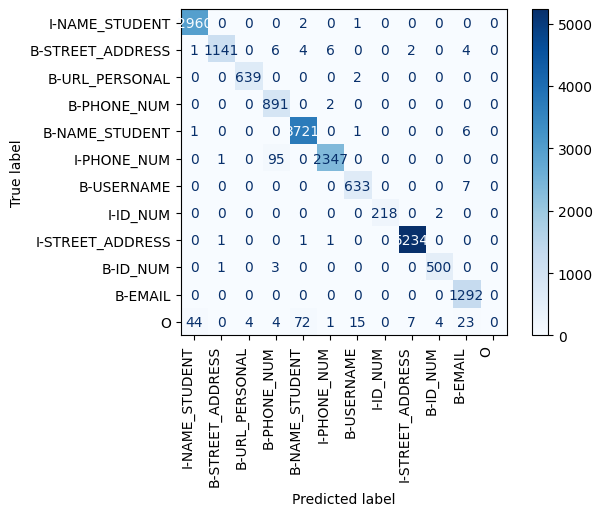

In [96]:
confusion(scoring)

In [97]:
overall_f5 = fbeta_score(scoring['y'].to_list(),
            scoring['y_hat'].to_list(),
            beta=5,
            average='micro')
overall_f5

0.9837185929648241

In [108]:
def filter_df(condition, scoring = scoring):
  return (test
       .select(pl.col('document', 'db_source'))
       ).join(
    scoring.lazy()
    ,on = 'document'
 ).filter(pl.col('db_source') == condition).collect()


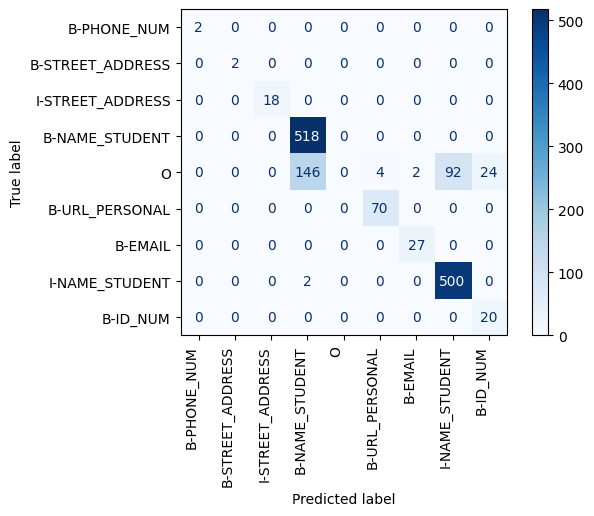

In [112]:
original =filter_df('orginal')
confusion(original)

In [113]:
fbeta_score(original['y'].to_list(),
            original['y_hat'].to_list(),
            beta=5,
            average='micro')

0.8051496172581768

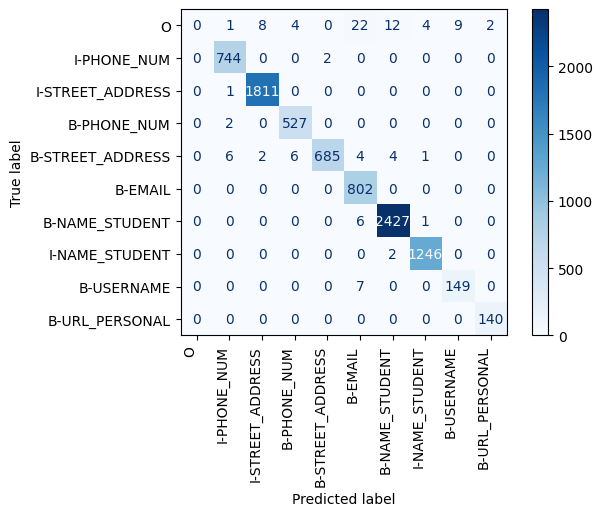

In [114]:
moth =filter_df('moth')
confusion(moth)

In [115]:
fbeta_score(moth['y'].to_list(),
            moth['y_hat'].to_list(),
            beta=5,
            average='micro')

0.9877272200995716

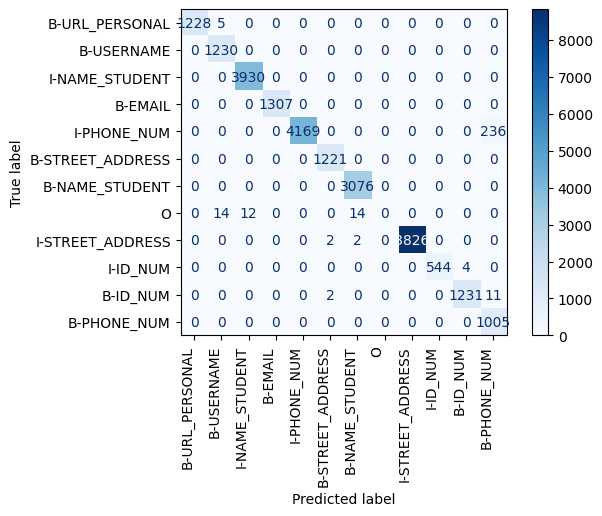

In [116]:
nick =filter_df('nicholas')
confusion(nick)

In [117]:
fbeta_score(nick['y'].to_list(),
            nick['y_hat'].to_list(),
            beta=5,
            average='micro')

0.9892407994584771